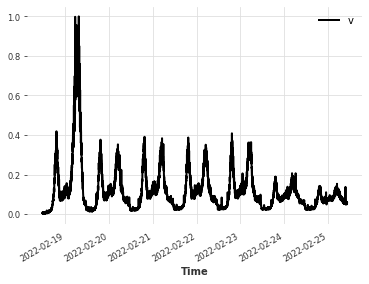

In [1]:
import sys
sys.path.append("../")
from pipeline.dataset.dataset_loader import DatasetLoader
import pandas as pd
from darts.models import (
    TFTModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk

import ray
from ray import tune
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"
ray.init(num_gpus=1)

dl =  DatasetLoader( '../../data/cpu_rate_test.csv', "Time", ["cpu_rate"], resample_freq="1min", augment=True)
train, val, test = dl.get_train_val_test()

In [2]:
def training_function(config):
     
#     if config["input_chunk_length"] < config["output_chunk_length"]:
#         return
    
    quantiles = [0.1, 0.5, 0.9]
    model = TFTModel(
        input_chunk_length=30,
        output_chunk_length=5,
        batch_size=64,
        hidden_size = config["hidden_size"],
        lstm_layers= config["lstm_layers"],
        num_attention_heads= config["num_attention_heads"],
        optimizer_kwargs= {'lr': config["lr"]},
        n_epochs=11, 
#         full_attention = False,
        dropout= config["dropout"],
#         hidden_continuous_size= config["hidden_continuous_size"],
        random_state=1,
        log_tensorboard=True,
        add_encoders={
            'datetime_attribute': {'past': ['dayofweek'], 'future': ['dayofweek']},
            "position": {"past": ["relative"], "future": ["relative"]},
            'custom': {'past': [lambda idx: idx.minute + (idx.hour * 60)],
                       'future': [lambda idx: idx.minute + (idx.hour * 60)]},
            'transformer': Scaler()
        },
        likelihood=QuantileRegression(
            quantiles=quantiles
        ), 
        work_dir=".",
        torch_device_str='cuda:0'
    )
        
    model.fit(train, val_series=val)
    
    pred = model.predict(n=30, num_samples=100)
    rr = 0.0
    for rho in quantiles:
        rr += rho_risk(val[:30], pred, rho=rho)
    rr = rr / len(quantiles)
    
    tune.report(mean_loss=rr)
    

In [ ]:
analysis = tune.run(
    training_function,
    max_concurrent_trials=8,
    resources_per_trial={'cpu': 1, 'gpu': 0.1},
    local_dir="logs/tft_hlnd",
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True),
    config={
#         "input_chunk_length": tune.grid_search([30]),
#         "output_chunk_length": tune.grid_search([5]),
#         "batch_size": tune.grid_search([64]),
        "hidden_size":  tune.grid_search([16, 64]),
        "lstm_layers": tune.grid_search([1,4]),
        "num_attention_heads":  tune.grid_search([4,8]),
        "dropout": tune.grid_search([0.05,0.1,0.2]),
        "lr": tune.grid_search([1e-3,1e-4])
        
    })

print("Best config: ", analysis.get_best_config(
    metric="mean_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

Trial name,status,loc,dropout,hidden_size,lr,lstm_layers,num_attention_heads,loss,iter,total time (s),neg_mean_loss
training_function_3a970_00008,RUNNING,130.149.248.55:84341,0.2,16,0.0001,1,4,,,,
training_function_3a970_00009,RUNNING,130.149.248.55:84332,0.05,64,0.0001,1,4,,,,
training_function_3a970_00010,RUNNING,130.149.248.55:84342,0.1,64,0.0001,1,4,,,,
training_function_3a970_00011,RUNNING,130.149.248.55:84338,0.2,64,0.0001,1,4,,,,
training_function_3a970_00012,RUNNING,130.149.248.55:84334,0.05,16,0.001,4,4,,,,
training_function_3a970_00013,RUNNING,130.149.248.55:84326,0.1,16,0.001,4,4,,,,
training_function_3a970_00014,RUNNING,130.149.248.55:84331,0.2,16,0.001,4,4,,,,
training_function_3a970_00015,RUNNING,130.149.248.55:84328,0.05,64,0.001,4,4,,,,
training_function_3a970_00000,TERMINATED,130.149.248.55:84327,0.05,16,0.001,1,4,0.19006,1,7437.9,-0.19006
training_function_3a970_00001,TERMINATED,130.149.248.55:84330,0.1,16,0.001,1,4,0.422506,1,7435.34,-0.422506


In [8]:
df

,mean_loss,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,neg_mean_loss,experiment_id,date,timestamp,...,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.input_chunk_length,config.output_chunk_length,config.batch_size
trial_id,,,,,,,,,,,,,,,,,,,,,
a0f4e_00000,0.011072,10262.293304,True,None,None,1,-0.011072,39b0fe389b2d4fa386b3f990c12ddaf7,2022-03-05_02-32-41,1646447561,...,43351,gpu06,130.149.248.55,10262.293304,0,1,"0_batch_size=8,input_chunk_length=30,output_ch...",30,5,8
a0f4e_00001,0.017422,4378.314337,True,None,None,1,-0.017422,a6f919b2dec349899e23aa0a405faf74,2022-03-05_00-54-40,1646441680,...,43361,gpu06,130.149.248.55,4378.314337,0,1,"1_batch_size=32,input_chunk_length=30,output_c...",30,5,32
a0f4e_00002,0.009323,3200.076867,True,None,None,1,-0.009323,6a8e36dd8b68446d887989bfc52160d2,2022-03-05_00-35-02,1646440502,...,43353,gpu06,130.149.248.55,3200.076867,0,1,"2_batch_size=64,input_chunk_length=30,output_c...",30,5,64
a0f4e_00003,0.025612,2739.209643,True,None,None,1,-0.025612,5ba25cc4cf294c4eaf17bb5759aedc15,2022-03-05_00-27-21,1646440041,...,43357,gpu06,130.149.248.55,2739.209643,0,1,"3_batch_size=128,input_chunk_length=30,output_...",30,5,128
a0f4e_00004,0.017438,2099.756339,True,None,None,1,-0.017438,fe06a06e88b846c596c51559f0894f41,2022-03-05_00-16-42,1646439402,...,43362,gpu06,130.149.248.55,2099.756339,0,1,"4_batch_size=256,input_chunk_length=30,output_...",30,5,256
